---
title: ""
author: ""
date: ""

format:
  pdf:
    pdf-engine: xelatex        # use XeLaTeX to avoid encoding issues and support better fonts
    keep-tex: false            # do not keep intermediate .tex file
    toc: false                 # do NOT generate Table of Contents automatically
    lof: false                 # do NOT generate List of Figures automatically
    lot: false                 # do NOT generate List of Tables automatically

number-sections: false          # add numbering to section headers

lang: en                       # set document language to English
encoding: UTF-8                # ensure UTF-8 encoding

code-overflow: wrap            # wrap long lines of code to avoid overflow in PDF
df-print: kable                # render data frames as kable tables instead of console text

execute:
  echo: true                   # show code in output
  warning: false               # suppress warnings in output
  message: false               # suppress messages (e.g., from library loading)
  code-fold: false             # do not fold code chunks
---


\clearpage
# Group Coursework 1 {.unnumbered .unlisted}

**Course:** BUSI70623 Applied Econometrics  

**Assignment:** Group Coursework 1  

**Group:** Group 6  


---




**Group Members:**

- Niamh O’Hara  
- Katarina Reiten  
- Zakaria Achakane  
- Kiril Grozdev  
- Saanya Xavier  

\clearpage

\tableofcontents
\listoffigures
\listoftables
\clearpage

# 1.0 Introduction
Comment

## 1.1 Data Preparation

In [1]:
# Load libraries
library(lmtest)
library(writexl)
library(sandwich)
library(ggplot2)
library(xts)
library(dplyr)
library(lubridate)
library(knitr)
library(data.table)
library(tidyverse)
library(tidyr)

# Load datasets
rates <- read.csv("DFF (Monthly).csv")
ff3_raw <- read.csv("F-F_Research_Data_Factors.csv", skip = 3)
industry12_raw <- read.csv("12_Industry_Portfolios.csv", skip = 11)
industry49_raw <- read.csv("49_Industry_Portfolios.csv", skip = 11)

# Clean interest rate data
rates <- rates %>%
  rename(date = observation_date,
         interest_rate = DFF) %>%     # rename variables
  mutate(date = as.Date(date)) %>%    # convert to date format
  select(date, interest_rate) %>%     # keep only relevant variables
  distinct(date, .keep_all = TRUE)    # one observation per month

# Clean Fama-French 3-factor data
ff3 <- ff3_raw %>%
  rename(raw_date = X) %>%
  filter(raw_date != "Annual") %>%    # remove annual observations
  mutate(
    date = as.Date(paste0(raw_date, "01"), "%Y%m%d"),  # convert to date
    market_excess_return = suppressWarnings(as.numeric(Mkt.RF)) / 100
  ) %>%
  select(date, market_excess_return) %>%               # keep relevant variables
  distinct(date, .keep_all = TRUE)                     # one row per month

# Restrict sample period
ff3 <- ff3 %>%
  filter(date >= as.Date("2000-01-01"))                # keep observations from 2000 onwards

# Clean 12 industry portfolios
industry12 <- industry12_raw %>%
  rename(raw_date = X) %>%
  filter(raw_date != "Annual") %>%                     # remove annual observations
  mutate(date = as.Date(paste0(raw_date, "01"), "%Y%m%d")) %>%  # convert to date
  select(-raw_date) %>%                                # drop raw date column
  mutate(
    across(-date, ~ suppressWarnings(as.numeric(.)) / 100)
  ) %>%                                                # ensure numeric + convert to decimals
  distinct(date, .keep_all = TRUE)                     # one row per month

# Extract Toys industry portfolio
toys <- industry49_raw %>%
  rename(raw_date = X) %>%
  filter(raw_date != "Annual") %>%                     # remove annual observations
  mutate(
    date = as.Date(paste0(raw_date, "01"), "%Y%m%d"),  # convert to date
    Toys = suppressWarnings(as.numeric(Toys)) / 100    # convert to decimal
  ) %>%
  select(date, Toys) %>%                               # keep relevant variables
  distinct(date, .keep_all = TRUE)                     # one observation per month

# Merge datasets
data_merged <- ff3 %>%
  left_join(rates, by = "date") %>%        # merge interest rates
  left_join(toys, by = "date") %>%         # merge Toys portfolio
  left_join(industry12, by = "date") %>%   # merge 12 industry portfolios
  arrange(date) %>%
  mutate(d_interest_rate = interest_rate - lag(interest_rate)) %>%
  filter(!is.na(d_interest_rate))           # drop NA 

# Check that merging did not change the number of observations
nrow(ff3) == nrow(data_merged)


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::lag() to make sure you're not using dplyr::lag(), or you can add #
# conflictRules('dplyr', exclude = 'lag') to your .Rprofile to stop           #
# dplyr from breaking base R's lag() function.                                #
#                                                                             #
# Code in packages is not affected. It's protected by 

[1] FALSE

In [2]:
#| tbl-cap: "First six observations of the merged dataset"
#| tbl-label: tbl-merged-preview
#| tbl-pos: "H"

# View first observations of the merged dataset
data_merged %>%
  select(date, market_excess_return, interest_rate, Toys) %>%  # select key variables
  head() %>%
  knitr::kable(digits = 3)




|date       | market_excess_return| interest_rate|   Toys|
|:----------|--------------------:|-------------:|------:|
|2000-02-01 |                0.025|          5.73|  0.004|
|2000-03-01 |                0.052|          5.85|  0.078|
|2000-04-01 |               -0.064|          6.02|  0.001|
|2000-05-01 |               -0.044|          6.27|  0.011|
|2000-06-01 |                0.047|          6.53| -0.017|
|2000-07-01 |               -0.025|          6.54| -0.099|

# 2.0 Harmonising, Visualising, and Interpreting Data

Comment 

## 2.1 Time series central bank policy rate (US)

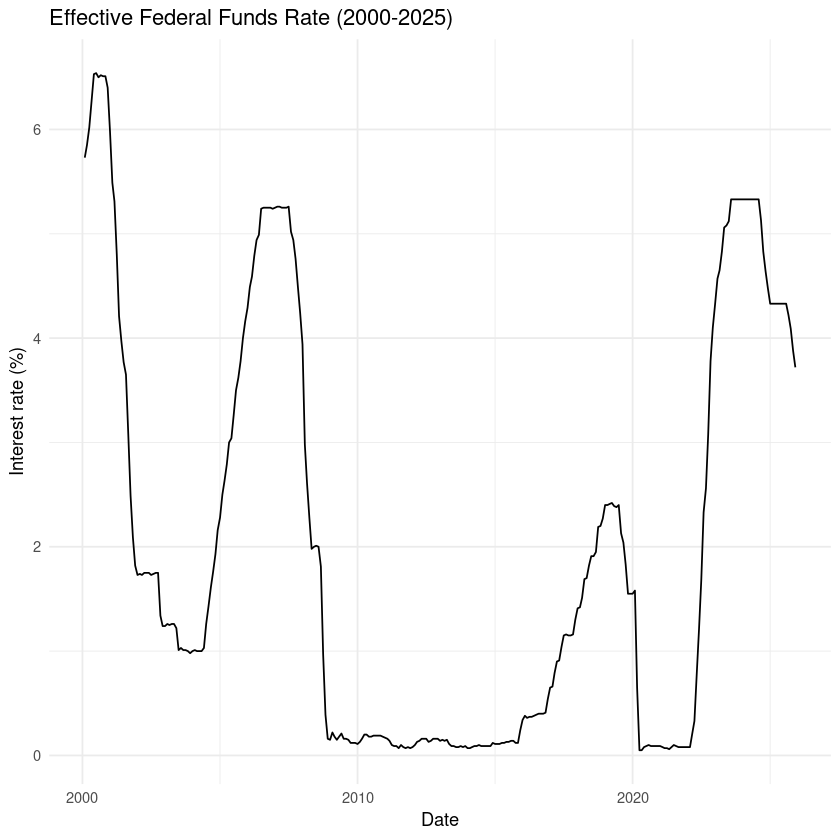

In [3]:
#| fig-cap: "Time series effective federal funds rate from 2000 to 2025"

ggplot(data_merged, aes(x = date, y = interest_rate)) +
  geom_line(na.rm = TRUE) +
  labs(
    title = "Effective Federal Funds Rate (2000-2025)",
    x = "Date",
    y = "Interest rate (%)"
  ) +
  theme_minimal()

  ggsave("interest_rate_timeseries.png", width = 7, height = 4)


## 2.2 Time series excess returns

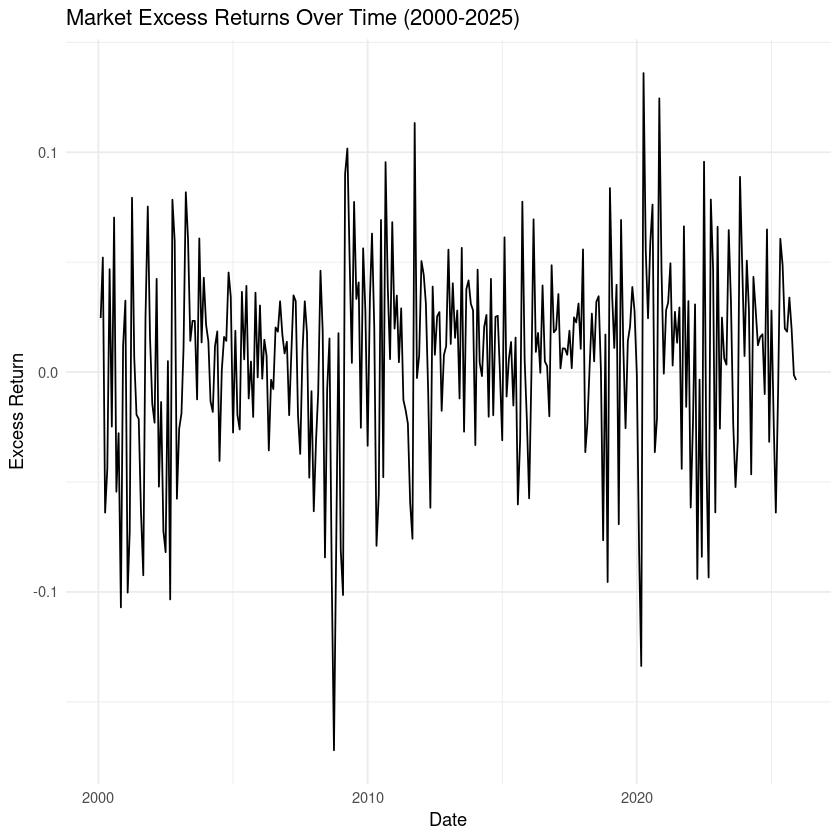

In [4]:
#| fig-cap: "Time series market excess returns from 2000 to 2025"

ggplot(data_merged, aes(x = date, y = market_excess_return)) +
  geom_line() +
  labs(
    title = "Market Excess Returns Over Time (2000-2025)",
    x = "Date",
    y = "Excess Return"
  ) +
  theme_minimal()

ggsave("market_excess_returns.png", width = 7, height = 4)


## 2.3 Time series returns for each of the 12 industries

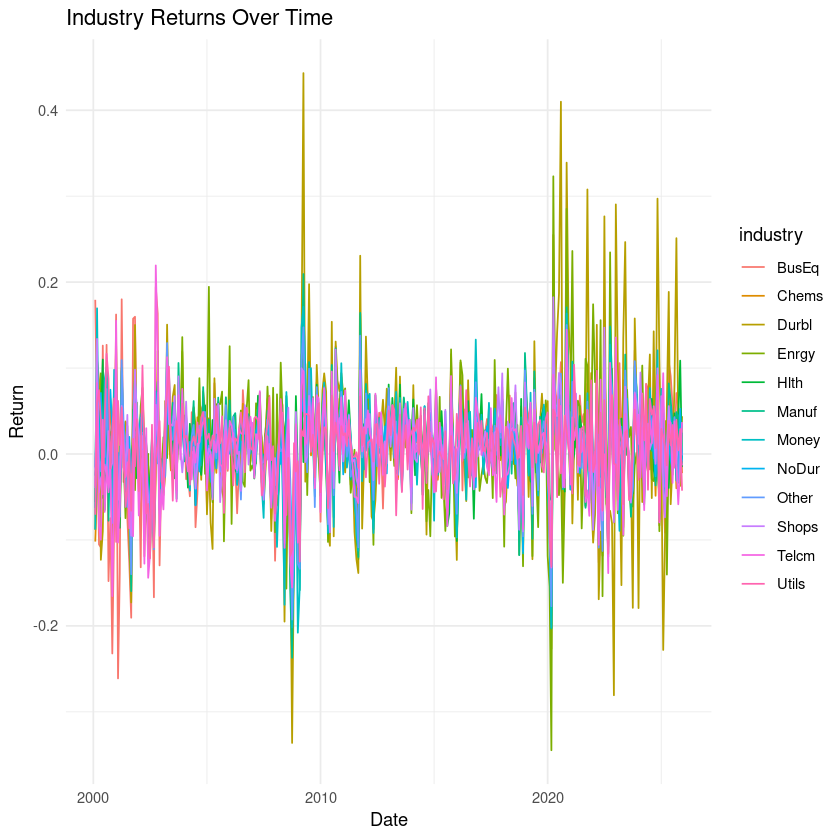

In [5]:
#| fig-cap: "Time series 12 industry portfolios from 2000 to 2025"

industry12_long <- data_merged %>%
  select(date, NoDur, Durbl, Manuf, Enrgy, Chems, BusEq,
         Telcm, Utils, Shops, Hlth, Money, Other) %>%
  pivot_longer(
    cols = -date,
    names_to = "industry",
    values_to = "return"
  )

ggplot(industry12_long, aes(x = date, y = return, color = industry)) +
  geom_line() +
  labs(
    title = "Industry Returns Over Time",
    x = "Date",
    y = "Return"
  ) +
  theme_minimal()

ggsave("industry_returns_timeseries.png", width = 7, height = 4)


## 2.4 Time series returns Toys

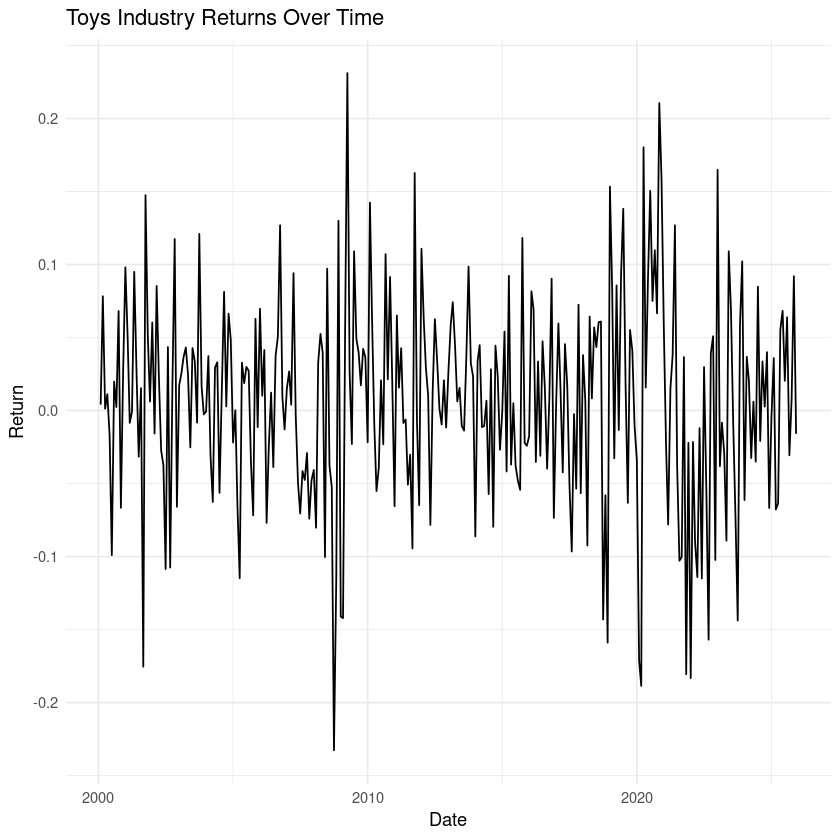

In [6]:
#| fig-cap: "Time series Toys industry portfolio from 2000 to 2025"

ggplot(data_merged, aes(x = date, y = Toys)) +
  geom_line() +
  labs(
    title = "Toys Industry Returns Over Time",
    x = "Date",
    y = "Return"
  ) +
  theme_minimal()

ggsave("toys_returns_timeseries.png", width = 7, height = 4)



# 3.0 Estimating Regressions

Comment 

In [7]:
# Calculate the monthly change in the policy interest rate 
data_merged <- data_merged %>%
  mutate(
    d_interest_rate = interest_rate - lag(interest_rate)
  )

## 3.1 Market excess return regression

In [8]:
# Estimate regression: market excess returns on changes in the interest rate
model_market <- lm(
  market_excess_return ~ d_interest_rate,
  data = data_merged
)

## 3.2 12 industries regression

In [9]:
# Names of the 12 industry portfolios
industry_names <- c(
  "NoDur", "Durbl", "Manuf", "Enrgy", "Chems",
  "BusEq", "Telcm", "Utils", "Shops",
  "Hlth", "Money", "Other"
)

# Estimate regressions industry by industry
industry_models <- list()

for (i in industry_names) {

  industry_models[[i]] <- lm(
    as.formula(paste(i, "~ d_interest_rate")),
    data = data_merged
  )
}

## 3.3 Toys sub-industry regression

In [10]:
# Estimate regression: Toys industry returns on changes in the interest rate
model_toys <- lm(
  Toys ~ d_interest_rate,
  data = data_merged
)

## 3.4 Regression Analysis Results

In [11]:
#| tbl-cap: "Regression Analysis Results"
#| tbl-pos: "H"

results <- data.frame(
  portfolio = c("Market", "Toys", names(industry_models)),
  beta = 100 * c(
    coef(model_market)["d_interest_rate"],
    coef(model_toys)["d_interest_rate"],
    sapply(industry_models, function(m) coef(m)["d_interest_rate"])
  ),
  ci_low = 100 * c(
    confint(model_market)["d_interest_rate", 1],
    confint(model_toys)["d_interest_rate", 1],
    sapply(industry_models, function(m) confint(m)["d_interest_rate", 1])
  ),
  ci_high = 100 * c(
    confint(model_market)["d_interest_rate", 2],
    confint(model_toys)["d_interest_rate", 2],
    sapply(industry_models, function(m) confint(m)["d_interest_rate", 2])
  ),
  r_squared = c(
    summary(model_market)$r.squared,
    summary(model_toys)$r.squared,
    sapply(industry_models, function(m) summary(m)$r.squared)
  ),
  n = c(
    nobs(model_market),
    nobs(model_toys),
    sapply(industry_models, nobs)
  ),
  p_value = c(
    summary(model_market)$coefficients["d_interest_rate", "Pr(>|t|)"],
    summary(model_toys)$coefficients["d_interest_rate", "Pr(>|t|)"],
    sapply(industry_models, function(m)
      summary(m)$coefficients["d_interest_rate", "Pr(>|t|)"])
  )
)

results$significant_5 <- results$p_value < 0.05

results_rounded <- results
num_cols <- sapply(results_rounded, is.numeric)
results_rounded[num_cols] <- round(results_rounded[num_cols], 3)

knitr::kable(results_rounded, booktabs = TRUE)




|portfolio |  beta| ci_low| ci_high| r_squared|   n| p_value|significant_5 |
|:---------|-----:|------:|-------:|---------:|---:|-------:|:-------------|
|Market    | 2.751| -0.022|   5.525|     0.012| 310|   0.052|FALSE         |
|Toys      | 0.506| -3.829|   4.840|     0.000| 310|   0.819|FALSE         |
|NoDur     | 2.932|  0.746|   5.118|     0.022| 310|   0.009|TRUE          |
|Durbl     | 1.150| -4.695|   6.995|     0.000| 310|   0.699|FALSE         |
|Manuf     | 4.182|  0.673|   7.691|     0.018| 310|   0.020|TRUE          |
|Enrgy     | 4.585|  0.266|   8.904|     0.014| 310|   0.038|TRUE          |
|Chems     | 1.862| -0.696|   4.420|     0.007| 310|   0.153|FALSE         |
|BusEq     | 1.702| -2.395|   5.800|     0.002| 310|   0.414|FALSE         |
|Telcm     | 2.813| -0.436|   6.062|     0.009| 310|   0.089|FALSE         |
|Utils     | 3.330|  0.765|   5.895|     0.021| 310|   0.011|TRUE          |
|Shops     | 1.244| -1.568|   4.056|     0.002| 310|   0.385|FALSE        

# 4.0 Causality

Comment 

# 5.0 Control variables

Comment 

# 6.0 Causality Revisited

Comment 

In [12]:
#Check date ranges

max(ff3$date)
max(rates$date)
max(data_merged$date)

min(ff3$date)
min(rates$date)
min(data_merged$date)

# Usable period
min(data_merged$date)
max(data_merged$date)

[1] "2025-12-01"

[1] "2026-02-01"

[1] "2025-12-01"

[1] "2000-01-01"

[1] "1954-07-01"

[1] "2000-02-01"

[1] "2000-02-01"

[1] "2025-12-01"